In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from tensorflow import keras
from tensorflow.keras import models, layers, regularizers

# Helper Functions

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Plot the confusion matrix of the classification task

# actual: true labels, given as a list of numerical values from 0 to num_classes - 1 (not one-hot encoded)
# predicted: predictions, given as a list of numerical values from 0 to num_classes - 1 (not one-hot encoded)
# labels: list of strings with the name of the classes

def plot_confusion_matrix(actual, predicted, labels):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(8, 8)})
  sns.set(font_scale=1.4)
  ax.set_xlabel('Predicted class')
  ax.set_ylabel('Actual class')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

###########################################################################
###########################################################################
###########################################################################

# Per class, extract the indexes of correctly and uncorrectly predicted data points

# model: name of the model
# x_train: training data
# ind_class: for which class do you want to observe the wrong predictions? Give it as a numeric value, not a string

def ind_correct_uncorrect(model, x_train, ind_class):
  ind = np.where(np.argmax(y_train, axis=1) == ind_class)[0]
  ind_correct = []
  ind_uncorrect = []
  preds = model.predict(x_train[ind], verbose=0)
  for i in range(len(ind)):
    if np.argmax(preds[i]) == np.argmax(y_train[ind[i]]):
      ind_correct.append(ind[i])
    else:
      ind_uncorrect.append(ind[i])
  return ind_correct, ind_uncorrect

###########################################################################
###########################################################################
###########################################################################

# Per class, plot a given number (i_max * j_max) of spectrograms

# i_max: number of rows of subplots
# j_max: number of columns of subplots
# x_train: training data
# ind_plot: indexes of the data points that you want to plot

def plot_spectrograms(i_max, j_max, x_train, ind_plot):
  fig, axs = plt.subplots(i_max, j_max, figsize=plt.figaspect(0.5))
  for i in range(i_max):
    for j in range(j_max):
      ind = ind_plot[i*j_max+j]
      axs[i, j].imshow(x_train[ind])
      axs[i, j].grid(False)
  fig.show()

###########################################################################
###########################################################################
###########################################################################

# Per class, print the predictions of those points that were wrongly classified

# model: name of the model
# x_train: training data
# y_train: training labels, one hot encoded
# ind_wrong: indexes of wrongly predicted points
# ind_class: for which class do you want to observe the wrong predictions? Give it as a numeric value, not a string
# labels: list of strings with the name of the classes

def print_wrong_prediction(model, x_train, y_train, ind_wrong, ind_class, labels):
  print('Wrongly predicted points for true class', labels[ind_class])
  for i in range(len(ind_wrong)):
    preds = model.predict(tf.expand_dims(x_train[ind_wrong[i]], axis=0), verbose=0)
    if np.argmax(preds) != np.argmax(y_train[ind_wrong[i]]):
      print('predicted class is', labels[np.argmax(preds)])

###########################################################################
###########################################################################
###########################################################################

# Compute Grad-CAM heatmap for a given data point and a hidden layer

# imag_array: image (represented as array) on which the heatmap will be produced
# model: name of the model
# layer_name: name of the layer on which the heatmap will be computed

def make_gradcam_heatmap(img_array, model, layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

###########################################################################
###########################################################################
###########################################################################

# Per class, plot a given number (i_max * j_max) of Grad-CAM heatmaps

# i_max: number of rows of subplots
# j_max: number of columns of subplots
# x_train: training data
# ind: indexes of the wrongly predicted data for that class
# model: name of model
# layer_name: name of layer on which to compute Grad-CAM

def plot_gradcam_spectrogram(i_max, j_max, x_train, ind, model, layer_name):
  fig, axs = plt.subplots(i_max, j_max, figsize=plt.figaspect(0.5))
  for i in range(i_max):
    for j in range(j_max):
      ind_ = ind[i*j_max+j]
      heatmap = make_gradcam_heatmap(tf.expand_dims(x_train[ind_], axis=0), model, layer_name)
      axs[i, j].matshow(heatmap)
      axs[i, j].grid(False)
  fig.show()

# Solution P1

In [4]:
# Load the data file (which is saved on google drive)
npzfile = np.load('./drive/MyDrive/ST456_WT2024_data_assign1.npz')
# Check contents (tables) of the npz file
contents = npzfile.files
print(contents)

# extract feature sets
x_train = npzfile['x_train']
x_val = npzfile['x_val']
x_test = npzfile['x_test']

# extract one hot encoded labels
y_train = npzfile['y_train']
y_val = npzfile['y_val']
y_test = npzfile['y_test']

# extract numerical labels
y_train_num = npzfile['y_train_num']
y_val_num = npzfile['y_val_num']
y_test_num = npzfile['y_test_num']

# the classes correspond to 4 music genres, in this order
classes = ['classical', 'disco', 'metal', 'rock']

['x_train', 'x_val', 'x_test', 'y_train', 'y_val', 'y_test', 'y_train_num', 'y_val_num', 'y_test_num']


In [5]:
# return the dimensions of relevant data sets
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3959, 80, 80, 1)
(1172, 80, 80, 1)
(3959, 4)
(1172, 4)


In [6]:
# create a deterministic environment (as specified in the assignment)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

# dynamically set the input shape for the features
input_shape = x_train.shape[1:]

# define the number of classes
n_classes = len(classes)

# build the model as specified in the assignment
model = models.Sequential([
    layers.Conv2D(4, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Conv2D(8, kernel_size=(5, 5), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Conv2D(16, kernel_size=(5, 5), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Flatten(),
    layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(n_classes, activation='softmax')
])

# compile the model with SGD optimizer as specified in the assignment
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# model summary to check the architecture
model.summary()

# train the model as specified and save the process in history
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_val, y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 4)         104       
                                                                 
 max_pooling2d (MaxPooling2  (None, 40, 40, 4)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 8)         808       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 16)        3216      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 16)        0

### 1. Model Parameter Analysis and Overfitting Considerations

The constructed model has a total of 84'382 trainable parameters.

#### Expectation of Overfitting
Overfitting is a phenomenon where a model learns patterns from the training data too well, including noise and outliers, which negatively affects its performance on new data. Several factors contribute to the likelihood of overfitting:

- **Data Size**: The large dataset consisting of 3'959 training instances, should provide a robust foundation for the model to learn varied and complex patterns without fitting its parameters too closely to the training set.
  
- **Model Complexity**: The model's complexity should be balanced against the volume and diversity of the training data. The current model's parameter count suggests a reasonable complexity.
  
- **Regularization Technique**: L2 regularization penalizes larger weights, encouraging the model to maintain smaller weight values. This simplifies the learned patterns and should improve the model's ability to generalize. The regularization layer in our model should reduce the likelihood of overfitting.

#### Conclusion
Considering the above, the model is not expected to suffer from significant overfitting. It should be able to capture the underlying patterns in the data effectively while maintaining a good level of generalization.


### 2. Plotting Loss and Accuracy

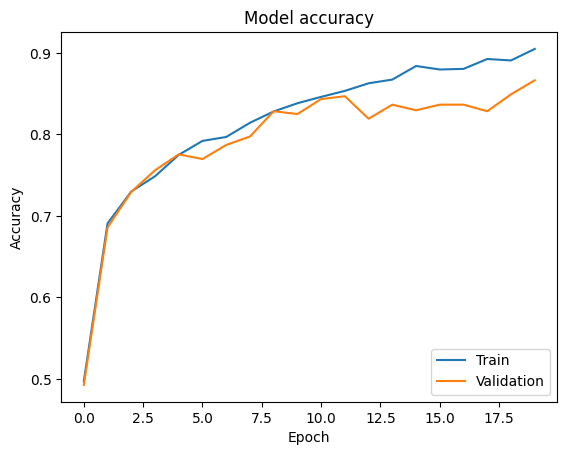

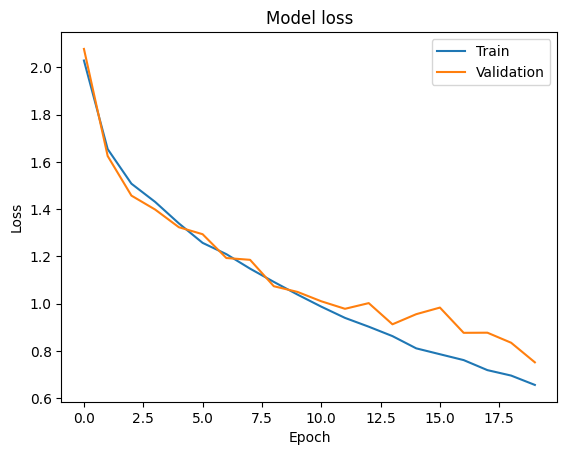

In [7]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


Looking at the plots, we can observe overfitting to some extent: After training for 10 epochs, the training and validation scores diverge slightly. While this is not dramatic, increasing the regularization rate or adding a dropout layer could further reduce overfitting.

### 3. Test set accuracy

In [8]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_accuracy}')

37/37 - 2s - loss: 0.7393 - accuracy: 0.8737 - 2s/epoch - 67ms/step
Test accuracy: 0.873720109462738


The accuracy on the test set aligns with the validation accuracy during the training process. Given the rather simple model, the accuracy of 87% seems reasonable and sufficient.

### 4. Confusion matrices

124/124 [==============================] - 8s 61ms/step


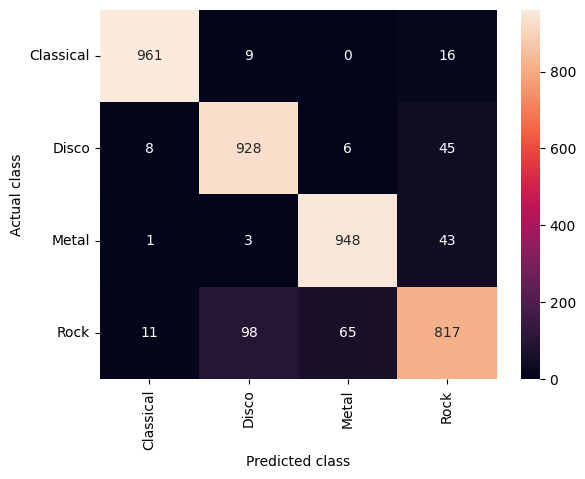

In [9]:
# Predictions for the train set
y_pred_train = np.argmax(model.predict(x_train), axis=1)
y_true_train = np.argmax(y_train, axis=1)

# Plotting the confusion matrix for the train set
plot_confusion_matrix(y_true_train, y_pred_train, labels=['Classical', 'Disco', 'Metal', 'Rock'])

37/37 [==============================] - 3s 81ms/step


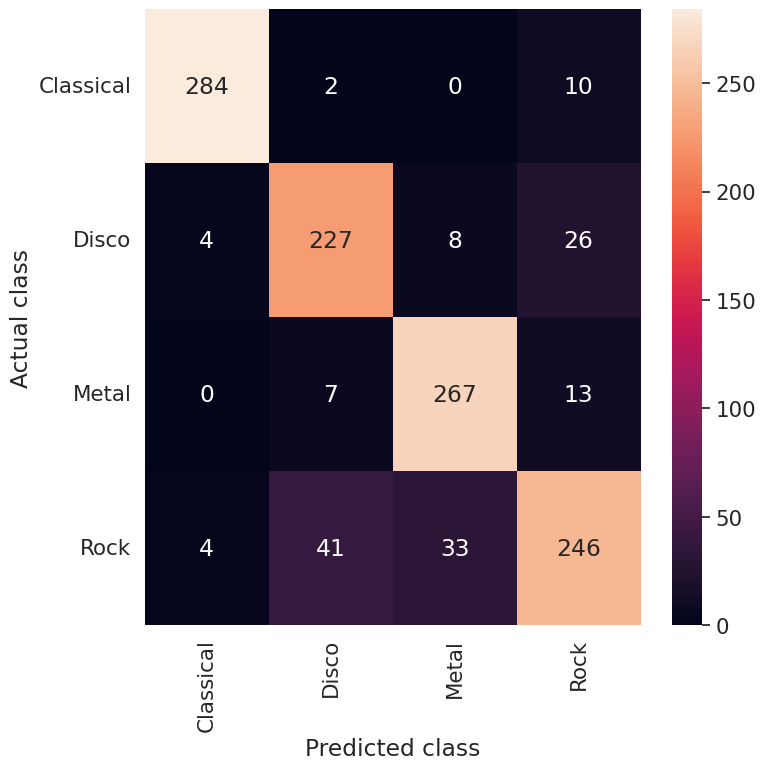

In [10]:
# Predictions for the test set
y_pred_test = np.argmax(model.predict(x_test), axis=1)
y_true_test = np.argmax(y_test, axis=1)

# Plotting the confusion matrix for the test set
plot_confusion_matrix(y_true_test, y_pred_test, labels=['Classical', 'Disco', 'Metal', 'Rock'])

The confusion matrices for both the test and training data display similar trends, indicating the model's overall effectiveness. However, the model encounters challenges in correctly identifying 'Rock' samples, often confusing them with disco and metal genres. Notably, the model performs well in distinguishing between 'Classical' and 'Metal' genres, with very few misclassifications observed between these categories.

In general, it is important to interpret confusion matrices with care, considering factors such as class imbalances, label ambiguities, and dataset biases. Altough, in this case this should not pose a significant problem.

### 5. Grad-CAM Spectograms



### 5.1 Comparing Spectograms of different Genres

1. **Classical Genre**
   - **Correctly Classified**: The classical genre tends to have a wide range, which appears as horizontal lines at consistent frequencies. The correctly classified spectrograms show these characteristics with clear and continuous horizontal bands. This distinctive pattern may partly explain the high classification accuracy for this genre.
   - **Incorrectly Classified**: The incorrectly classified spectrograms have more fragmented patterns, and more variance on the vertical axis. The horizontal lines are less pronounced.

2. **Disco Genre**
   - **Correctly Classified**: The plots for disco are harder to interpret. There are few patterns and the spectograms for each observation looks quite different. The notable absence of significant horizontal or vertical structures might be how the model is able to classify such observations as disco.
   - **Incorrectly Classified**: The incorrectly classified spectrograms show more structure, especially in the vertical dimension.

3. **Metal Genre**
   - **Correctly Classified**: The spectograms for the metal genre have little structure, except for some texture in the mid to high-frequency range and vertical elements in the lower half. Further, the correctly classified spectograms tend to be darker near the top.
   - **Incorrectly Classified**: The incorrectly classified spectrograms show more varied textural features, sometimes exhibiting similarties to the rock genre, which could be why the model misclassified them.

4. **Rock Genre**
   - **Correctly Classified**: Rock music typically features a strong backbeat and clear melodic lines. The correctly classified spectrograms show rhythmic vertical lines in the lower frequencies and some distinct patterns on higher levels that could represent guitar riffs or vocals.
   - **Incorrectly Classified**: The incorrectly classified spectrograms show dense structures with many horizontal and vertical patterns. They look similar to the missclassified metal spectograms, possibly causing difficulties for the model to classify them.

### General Observations:

It is difficult to compare the spectograms between genres, as the differences are subtle or hard to describe. However, there is a resemblance between the spectrograms associated with the metal and rock genres, which could explain the model's observed challenges in differentiating them. Further, the classical genre exhibits very distinct patterns, explaining why the model makes few classification mistakes.

(see spectograms below)


In [11]:
# to plot the correctly- and incorrectly classified spectograms we combine the ind_correct_uncorrect() function with the plot_spectograms() function

# function for the correctly classified spectograms
def plot_correct_spectrograms(model, x_data, y_data, class_name, class_index):
    # print the class that we are analyizing and return the indices of the correctly classified observations
    ind_correct, _ = ind_correct_uncorrect(model, x_data, class_index)
    # output class that is being analyzed
    print(f"Correct predictions for {class_name}")
    # set number of required plots (in case avilable number < 6)
    n_plots = min(len(ind_correct), 6)
    # plot the spectograms using the pre defined function
    plot_spectrograms(2, 3, x_train, ind_correct[:n_plots])

# same function for to incorrectly classified spectograms
# (it is easier to have a nicely structured layout in the jupyter notebook this way)
def plot_incorrect_spectrograms(model, x_data, y_data, class_name, class_index):
    _, ind_uncorrect = ind_correct_uncorrect(model, x_data, class_index)
    print(f"Incorrect predictions for {class_name}")
    n_plots = min(len(ind_uncorrect), 2 * 3)
    plot_spectrograms(2, 3, x_train, ind_uncorrect[:n_plots])


Correct predictions for classical


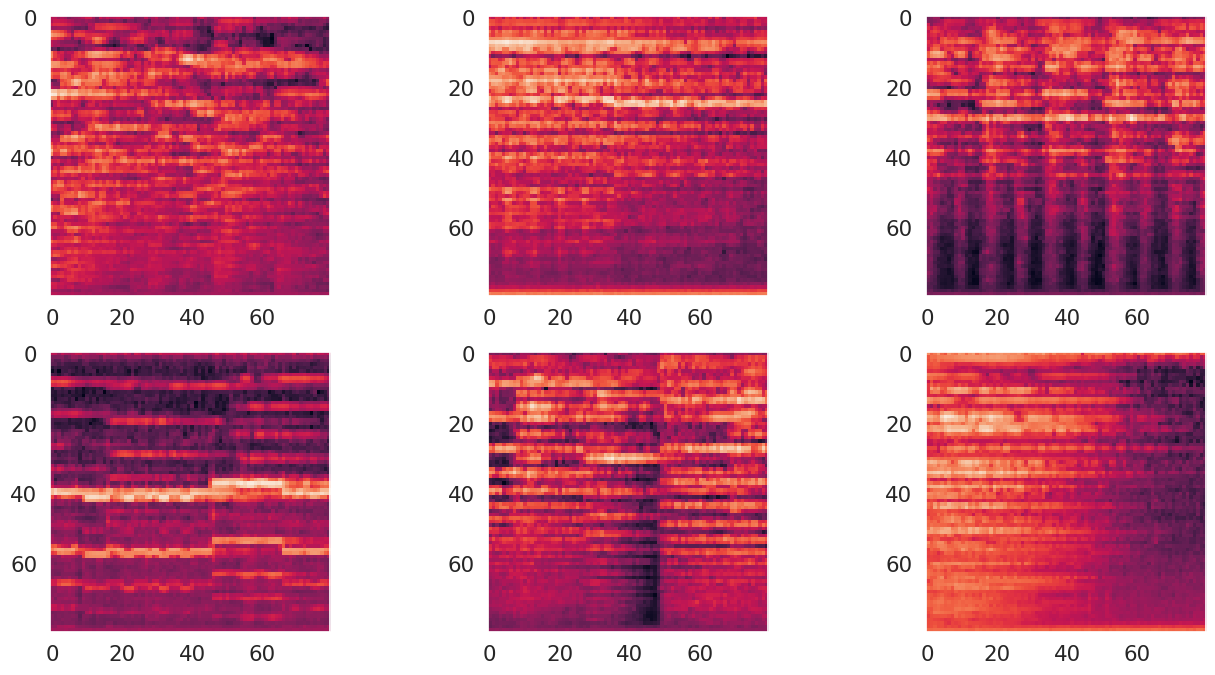

In [12]:
# call the function to plot spectrograms for the classical genre (correct)
plot_correct_spectrograms(model, x_train, y_train, 'classical', 0)

Incorrect predictions for classical


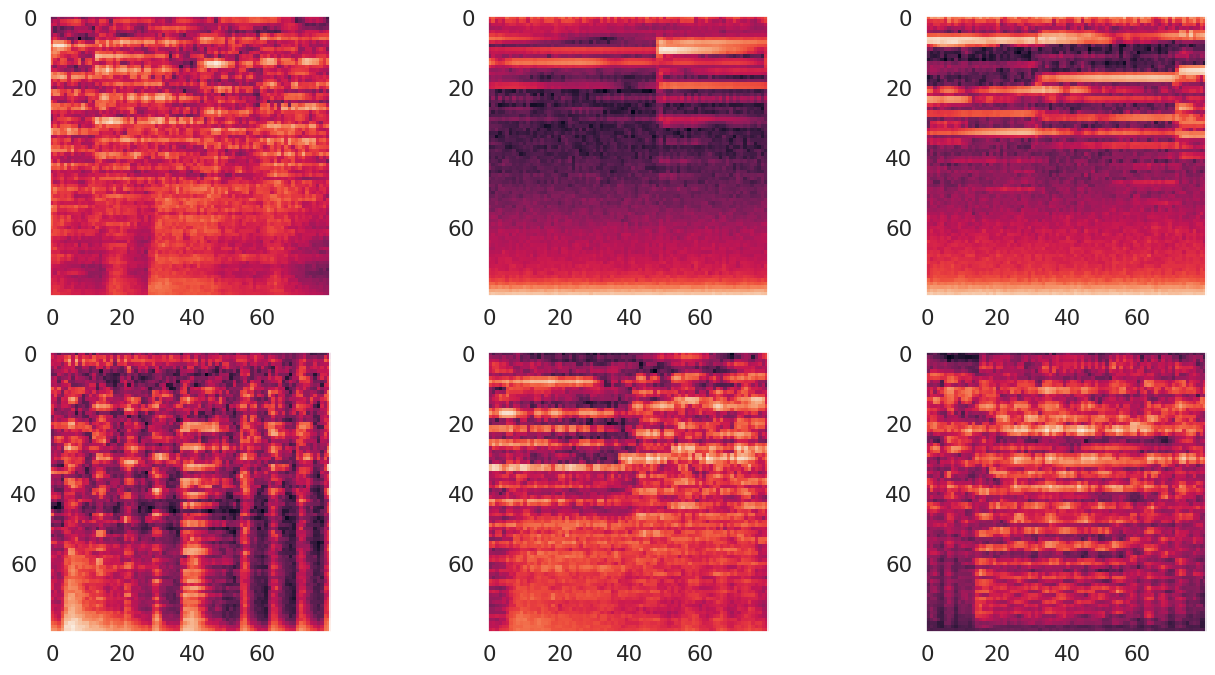

In [13]:
# call the function to plot spectrograms for the classical genre (incorrect)
plot_incorrect_spectrograms(model, x_train, y_train, 'classical', 0)

Correct predictions for disco


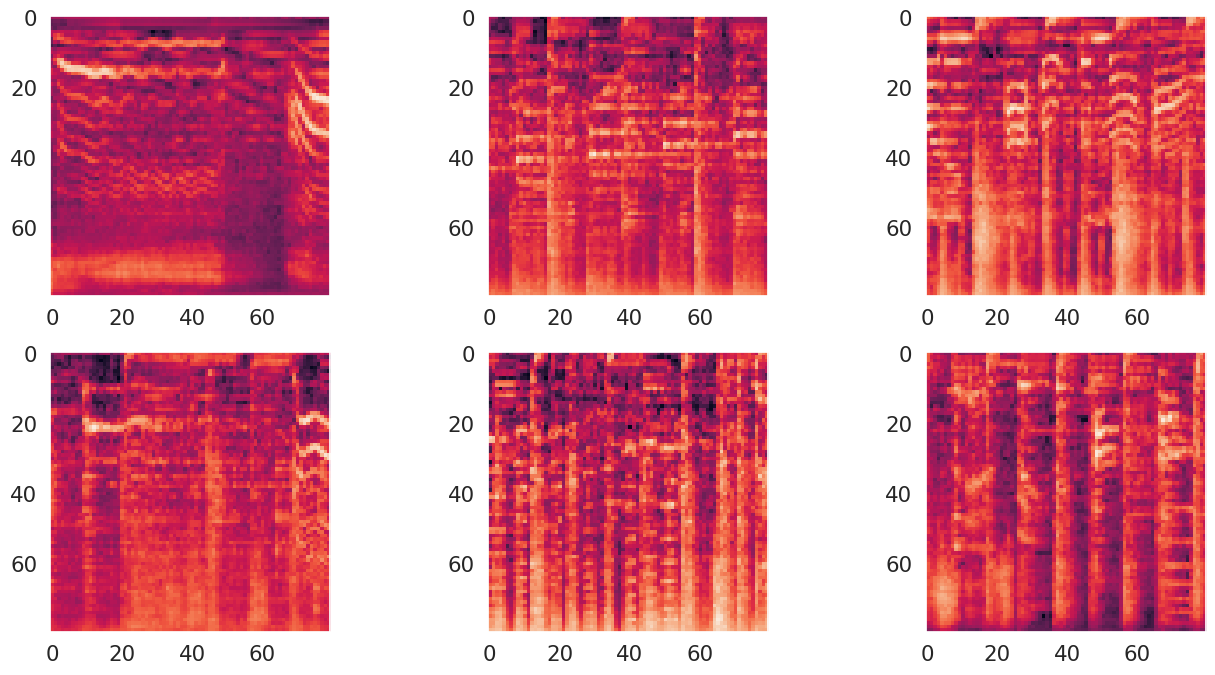

In [14]:
# call the function to plot spectrograms for the disco genre (correct)
plot_correct_spectrograms(model, x_train, y_train, 'disco', 1)

Incorrect predictions for disco


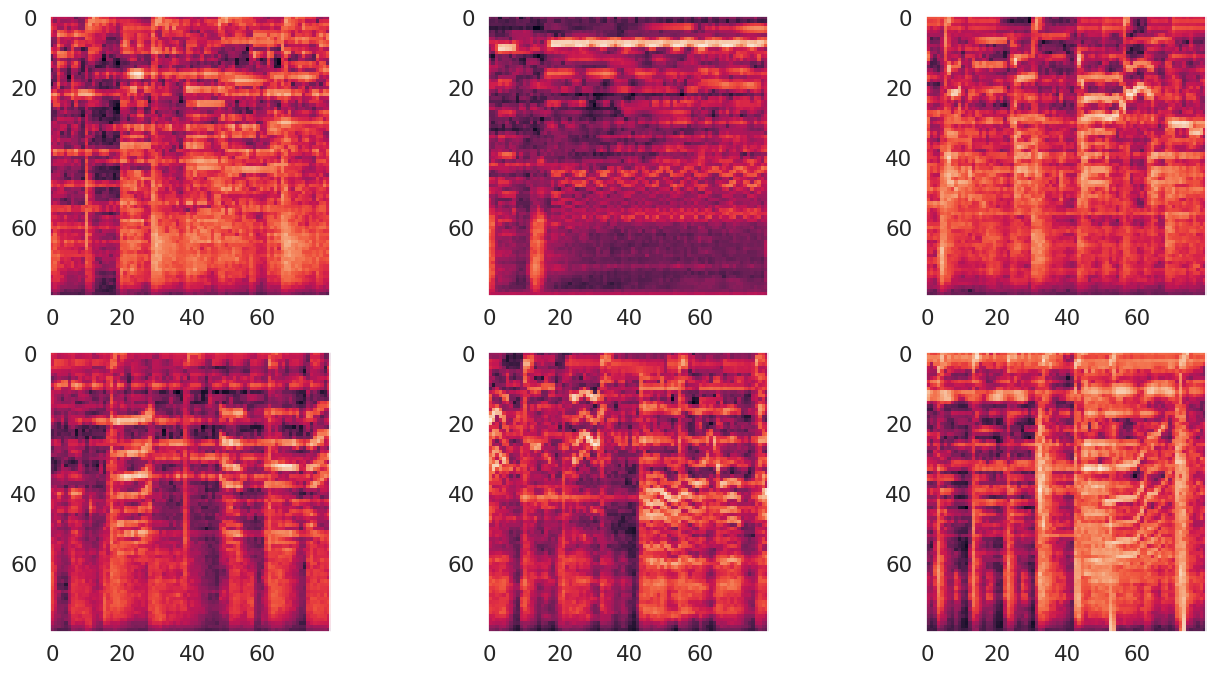

In [15]:
# call the function to plot spectrograms for the disco genre (incorrect)
plot_incorrect_spectrograms(model, x_train, y_train, 'disco', 1)

Correct predictions for metal


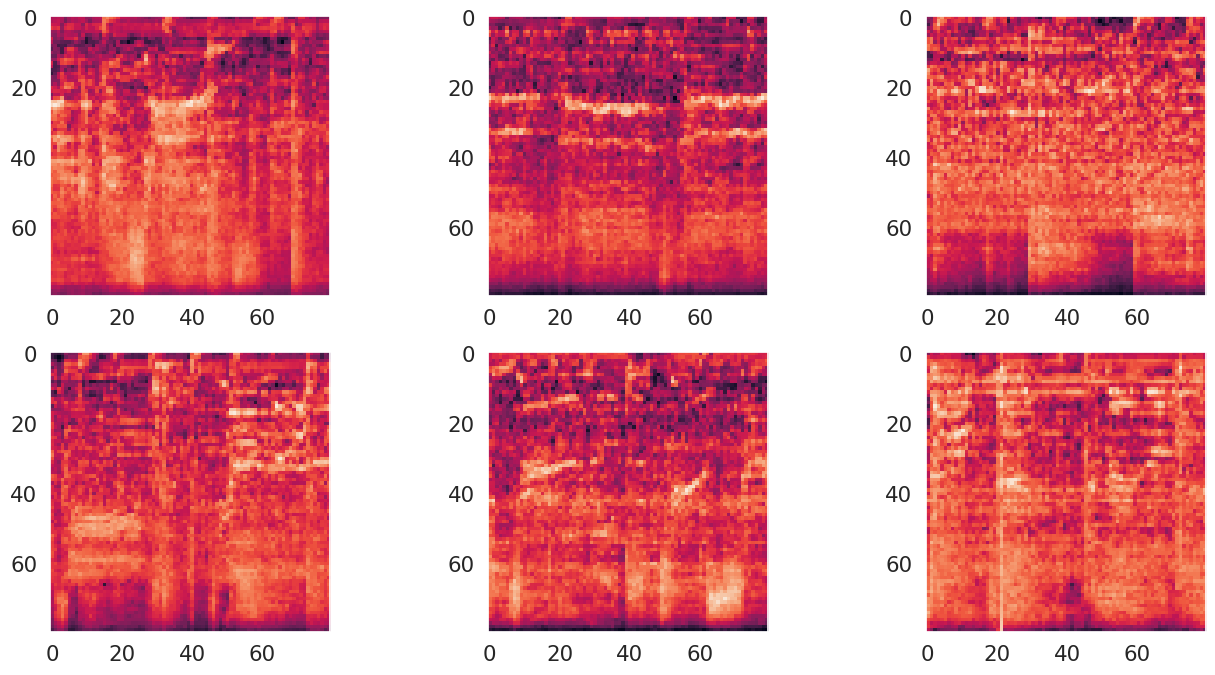

In [16]:
# call the function to plot spectrograms for the metal genre (correct)
plot_correct_spectrograms(model, x_train, y_train, 'metal', 2)

Incorrect predictions for metal


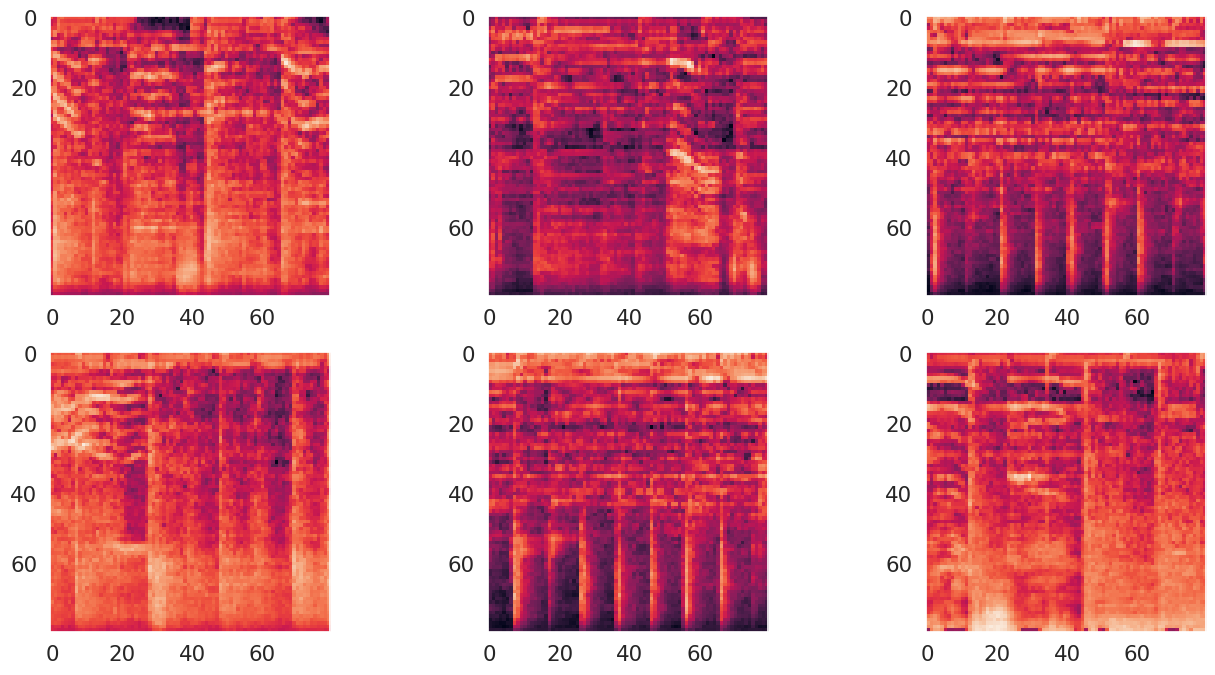

In [17]:
# call the function to plot spectrograms for the metal genre (incorrect)
plot_incorrect_spectrograms(model, x_train, y_train, 'metal', 2)

Correct predictions for rock


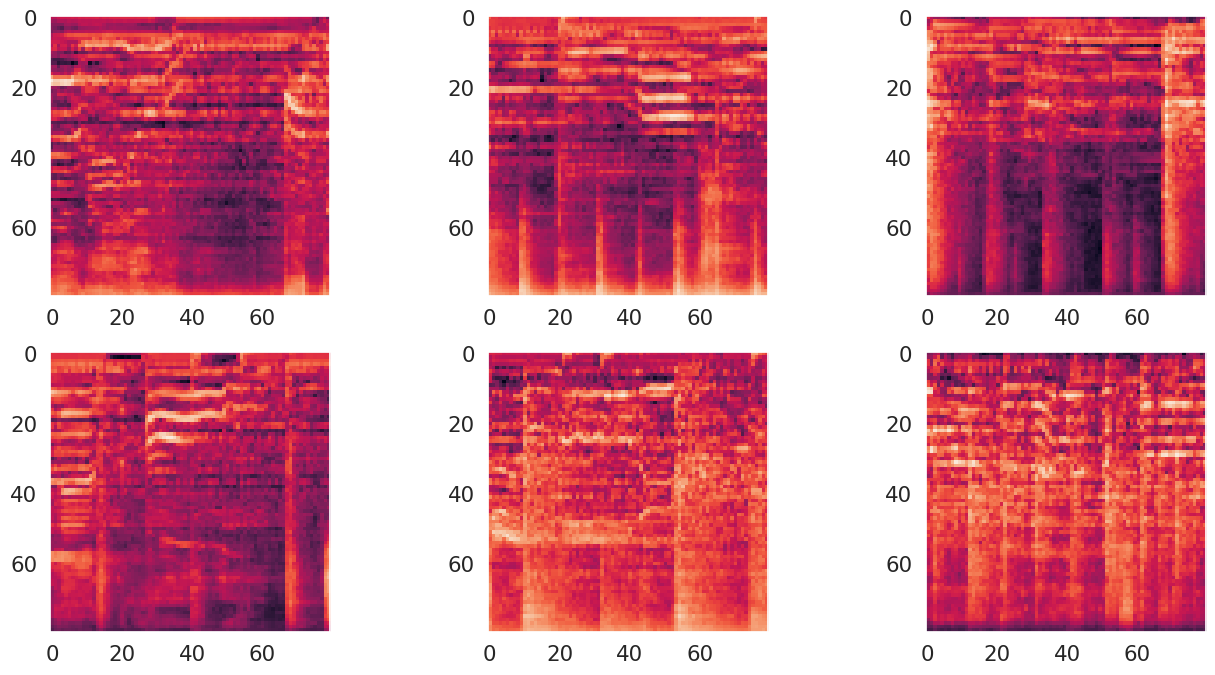

In [18]:
# call the function to plot spectrograms for the rock genre (correct)
plot_correct_spectrograms(model, x_train, y_train, 'rock', 3)

Incorrect predictions for rock


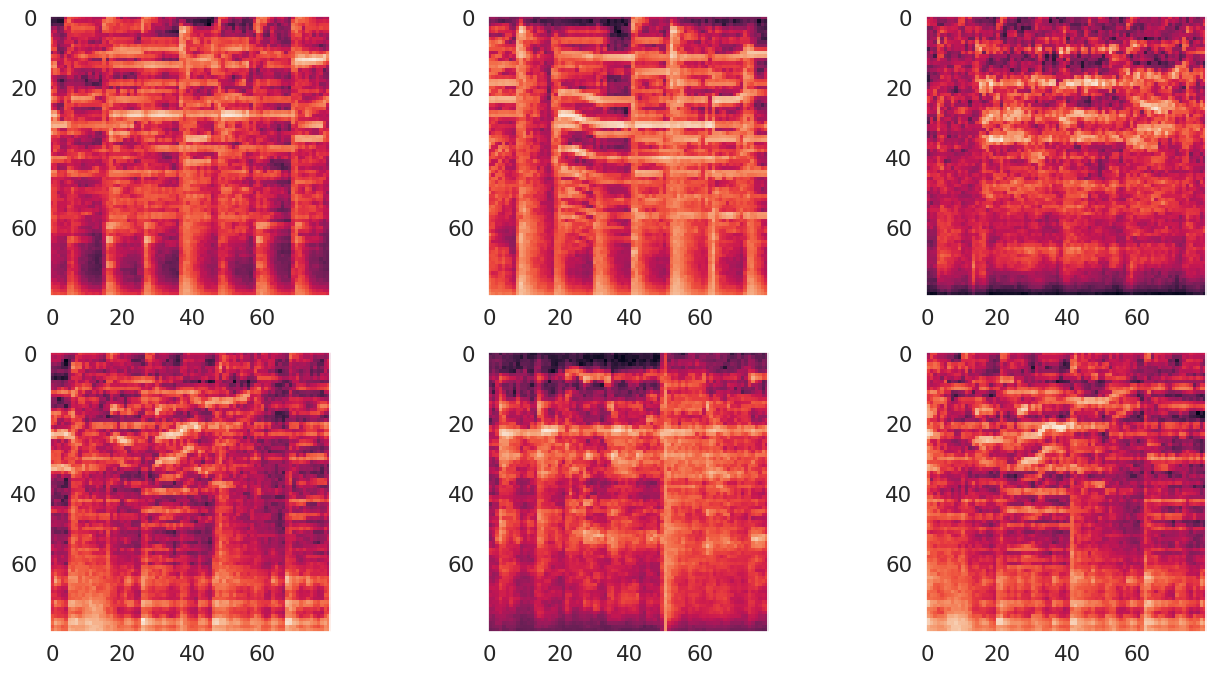

In [19]:
# call the function to plot spectrograms for the rock genre (incorrect)
plot_incorrect_spectrograms(model, x_train, y_train, 'rock', 3)

### 5.2

In [20]:
# combine the ind_correct_uncorrect() function and the print_wrong_prediction() function to print the first six wrongly predicted points per class
for ind_class, class_name in enumerate(classes):

    _, ind_uncorrect = ind_correct_uncorrect(model, x_train, ind_class)

    first_six_incorrect = ind_uncorrect[:6]

    print_wrong_prediction(model, x_train, y_train, first_six_incorrect, ind_class, classes)


Wrongly predicted points for true class classical
predicted class is rock
predicted class is rock
predicted class is rock
predicted class is disco
predicted class is rock
predicted class is disco
Wrongly predicted points for true class disco
predicted class is rock
predicted class is rock
predicted class is metal
predicted class is rock
predicted class is rock
predicted class is rock
Wrongly predicted points for true class metal
predicted class is rock
predicted class is rock
predicted class is rock
predicted class is rock
predicted class is rock
predicted class is rock
Wrongly predicted points for true class rock
predicted class is disco
predicted class is disco
predicted class is metal
predicted class is disco
predicted class is disco
predicted class is disco


### 5.3 Analysing Grad-CAM

The Grad-CAM heatmaps provide a visual interpretation of the regions within Mel spectrograms that influence the model's predictions across different music genres. We can observe notable differences in the activation between correctly and incorrectly classified samples, which offer insights into the model's decision-making process.

For correctly classified samples, the heatmaps are very active and show activations across a wide range. These patterns suggest the model has been able to extract relevant information based on the data point of the genre.

In contrast, the heatmaps for incorrectly classified samples reveal less distinct and more diffused activations. Often the model plots contain large black areas, indicating that much of the information contained in these samples has not significantly affected the model. These observations imply that the model struggles when defining features are not pronounced or are masked by other characteristics. This leads to low classification confidence and confusion with other genres that share similar features.

In general, the model seems to rely on pronounced, genre-specific patterns that, when absent or less defined, result in misclassification.

Again, it is difficult to compare genres based on these plots, however, a similar structure as for the spectograms can be observed: Classical and disco are quite distinct from the other genres, while metal and rock exhibit more similarities. This aligns with the observations in 5.2 and the confusion matrix.

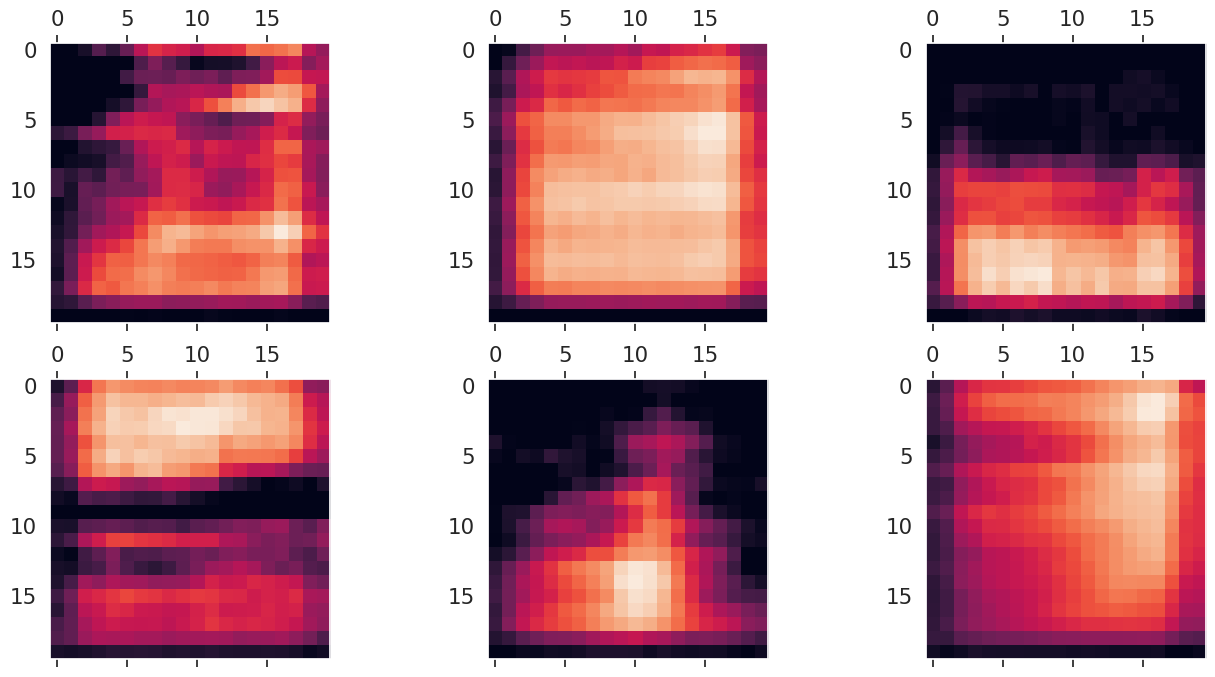

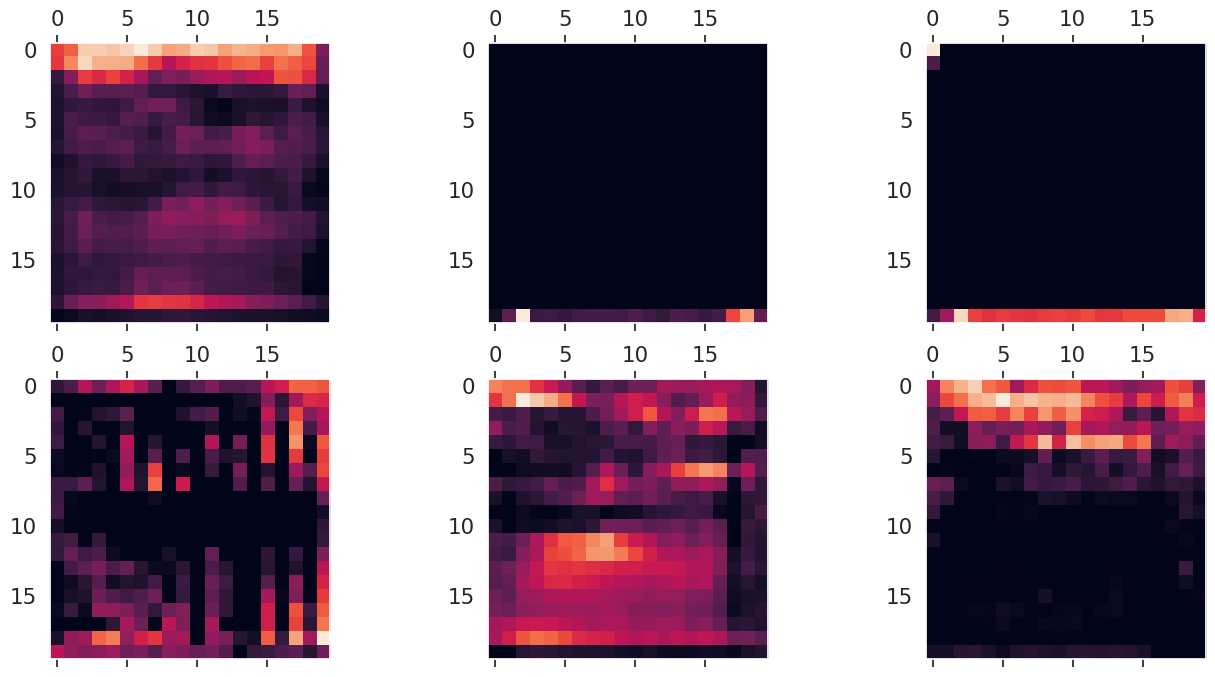

In [22]:
# store the name of the last convolutional layer for use in the Grad-CAM (name visible in model summary)
last_conv_layer_name = 'conv2d_2'

# combine the ind_correct_uncorrect() function and the plot_gradcam_spectrogram() function to plot the required Grad-CAMs for a given class
# for simplicity the function takes the class index instead of the class name
def plot_gradcam_for_correct_incorrect(model, x_data, y_data, classindex, last_conv_layer_name):

    ind_correct, ind_uncorrect = ind_correct_uncorrect(model, x_data, classindex)

    # here we output the plots for incorrectly- and correctly classified points in the same function in sequence
    if ind_correct:
        plot_gradcam_spectrogram(2, 3, x_data, ind_correct[:6], model, last_conv_layer_name)

    if ind_uncorrect:
      plot_gradcam_spectrogram(2, 3, x_data, ind_uncorrect[:6], model, last_conv_layer_name)

# plot the Grad-CAMs for the classical genre
plot_gradcam_for_correct_incorrect(model, x_train, y_train, 0, last_conv_layer_name)


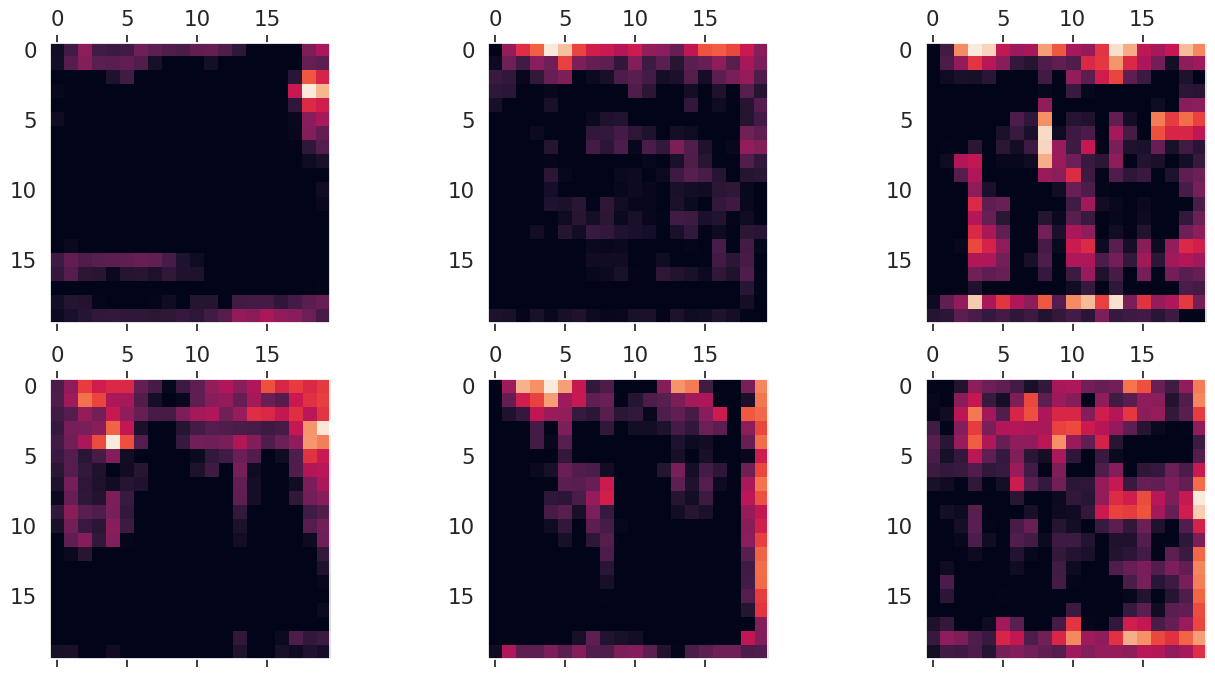

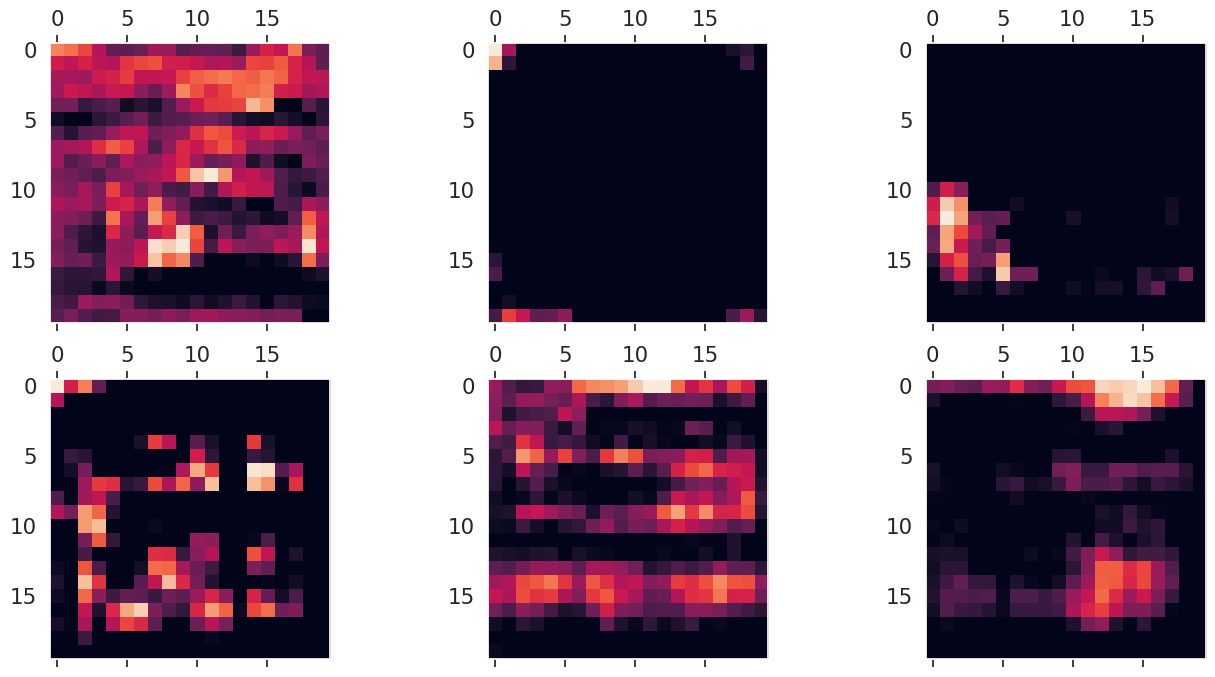

In [23]:
# plot the Grad-CAMs for the disco genre
plot_gradcam_for_correct_incorrect(model, x_train, y_train, 1, last_conv_layer_name)


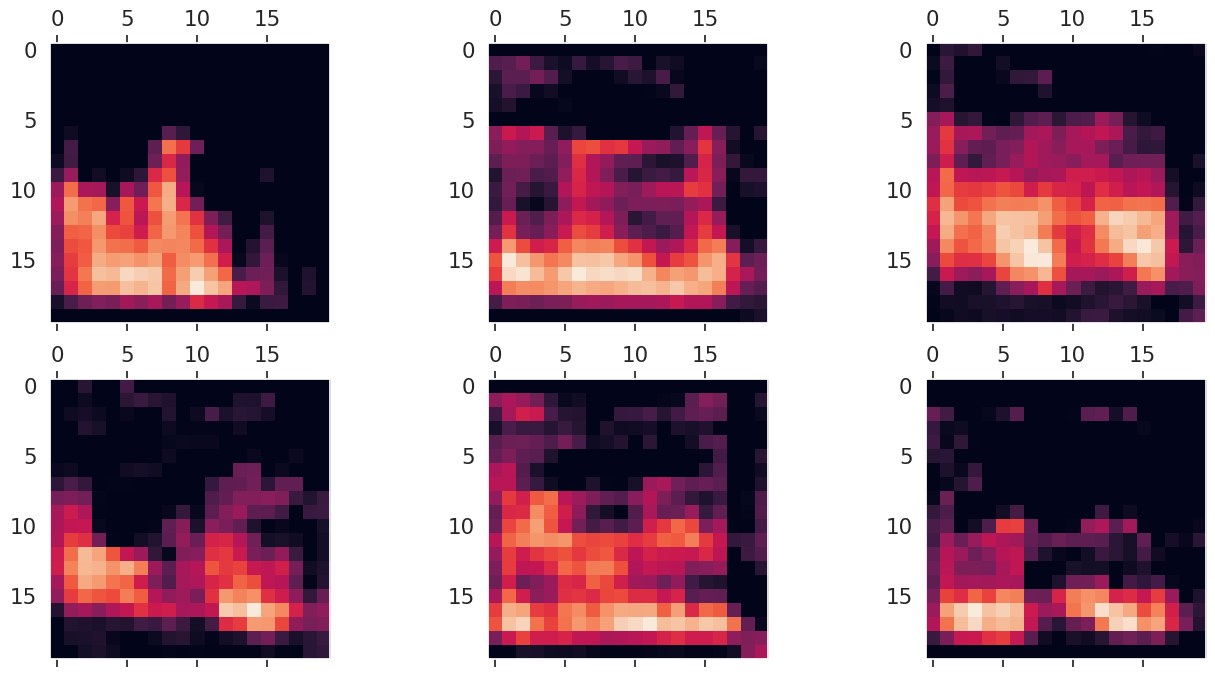

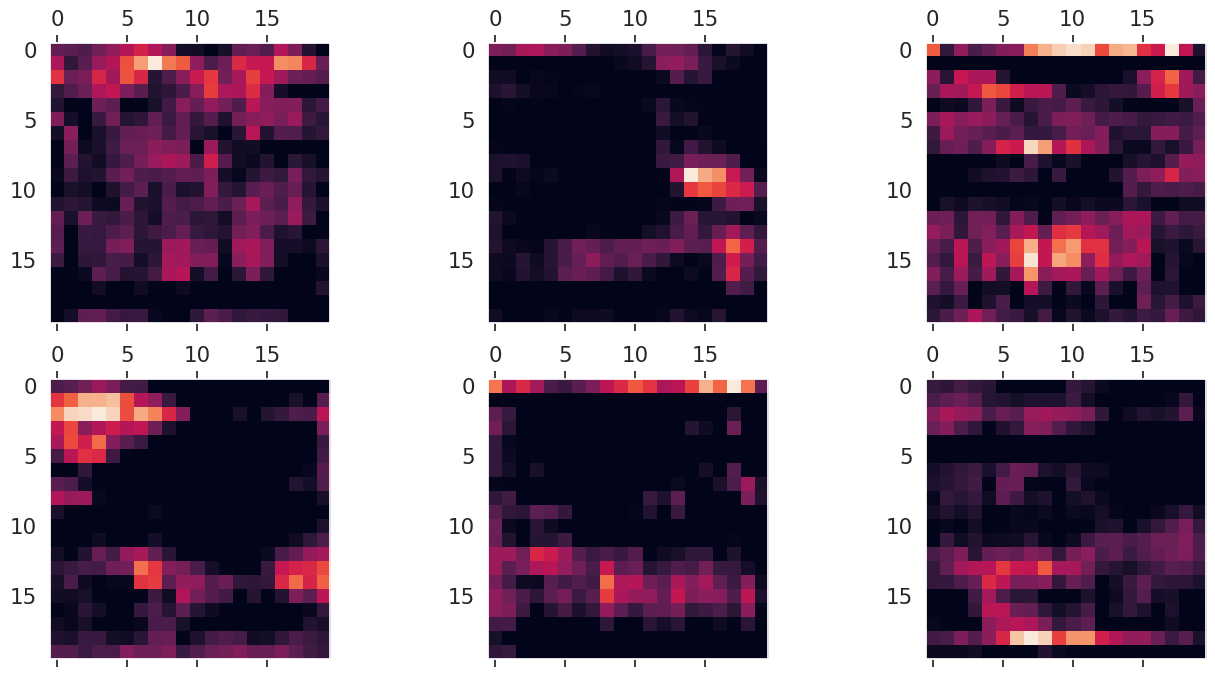

In [24]:
# plot the Grad-CAMs for the metal genre
plot_gradcam_for_correct_incorrect(model, x_train, y_train, 2, last_conv_layer_name)


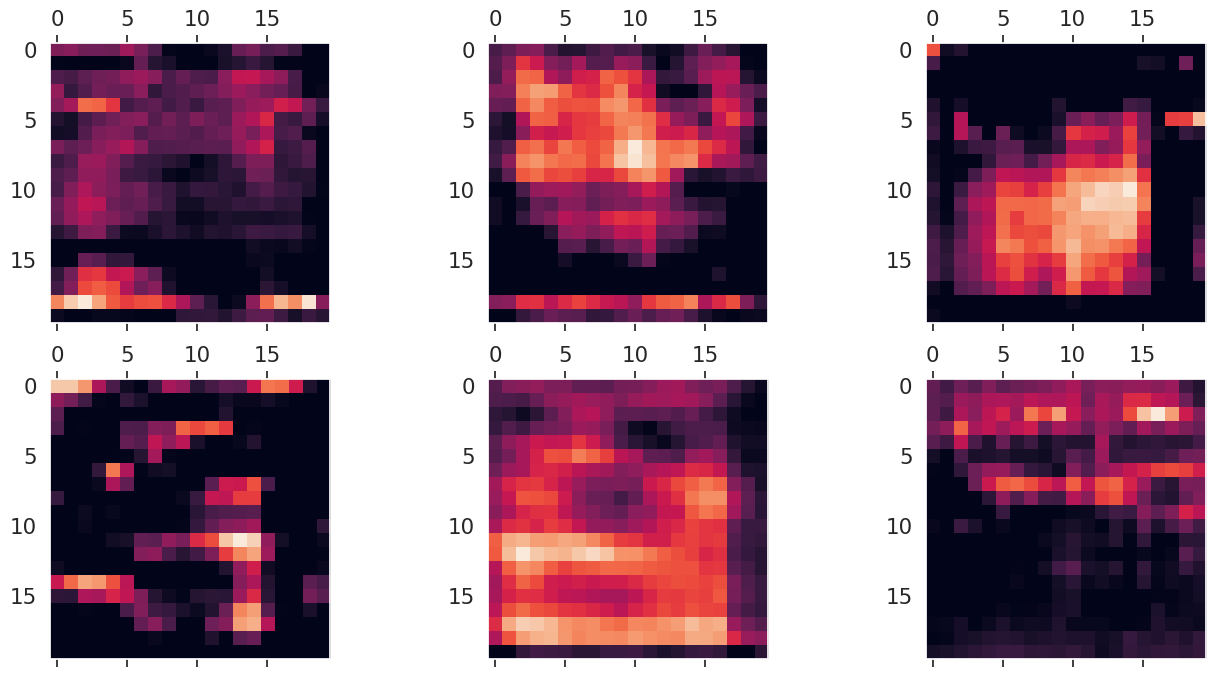

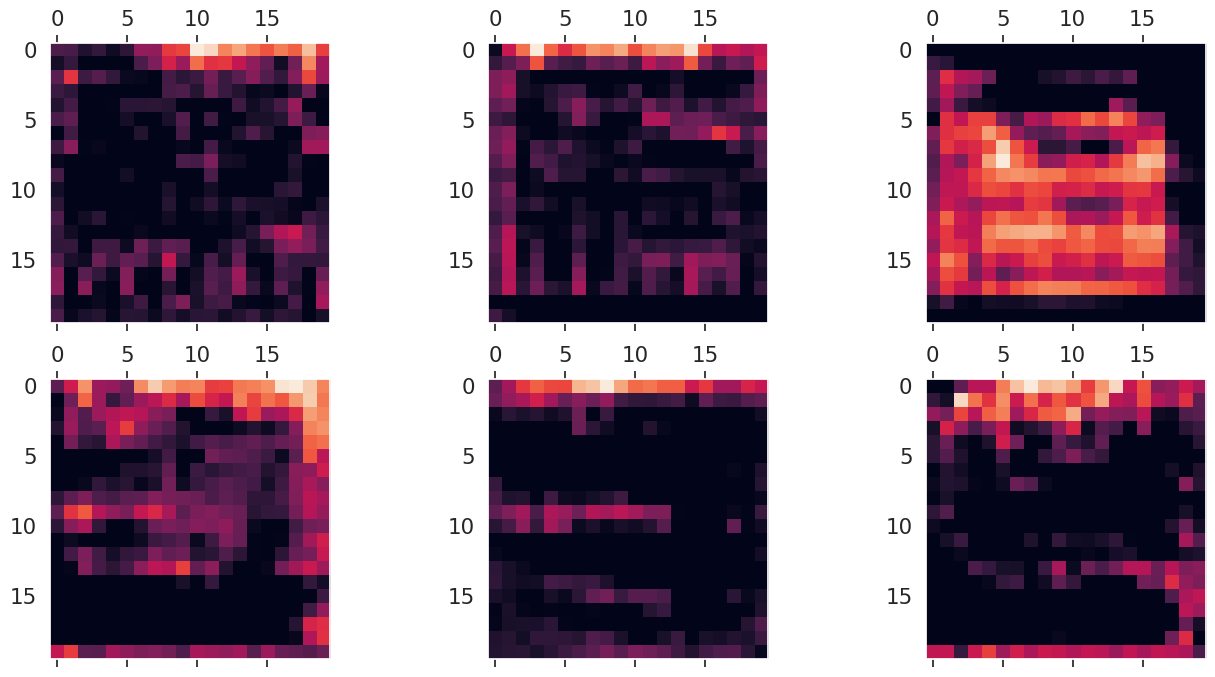

In [25]:
# plot the Grad-CAMs for the rock genre
plot_gradcam_for_correct_incorrect(model, x_train, y_train, 3, last_conv_layer_name)


### 6. Grad-CAM Interpretability
Grad-CAM provides visual explanations for the decisions made by CNN models, highlighting the influential regions in input data that guide the model's predictions. When applied to Mel spectrograms for music genre classification, Grad-CAM can reveal patterns/areas that the model recognizes as significant for distinguishing genres. Horizontal patterns may relate to rhythmic or temporal features, while vertical patterns could relate to harmonic or tonal content. If the brighter areas are more horizontal, it suggests the model is focusing on temporal patterns, while vertical brightness would suggest a focus on frequency-related features.

In general, this serves as a valuable tool for model interpretability, allowing us to understand the model's reasoning to some extent. However, it is important to note that such plots do not offer true explainability in terms of understanding the causal relationships between model input and output or the model's internal logic.

Grad-CAM is primarily effective with CNNs, including the ones we employ for this task. It is not useful for models without convolutional layers, like simple neural networks or RNNs. It does not work well on the very first layers of a model or on data that does not have clear spatial features, like some non-image data. Grad-CAM also is not suitable when the input data to the model is heavily altered before use. In other words, for this task it is appropriate to use Grad-CAM for insigths.

# P2

In [5]:
# run settings again as this part of the notebook is run in a T4 GPU session
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

# create an updated model architecture specifically fit to the spectogram classification task
def create_dual_stream_cnn(input_shape, num_classes):

    # input layer taking into account input shapes
    input_layer = layers.Input(shape=input_shape)

    # frequency stream
    # we use narrower filters initially to focus on capturing fine-grained frequency details
    freq = layers.Conv2D(32, (3, 1), activation='relu', padding='same')(input_layer)  # more focused filter
    freq = layers.Dropout(0.3)(freq)
    freq = layers.Conv2D(32, (3, 1), activation='relu', padding='same')(freq)
    # using separable convolutions with slightly broader filters as the depth increases
    freq = layers.SeparableConv2D(64, (5, 1), activation='relu', padding='same')(freq)
    freq = layers.MaxPooling2D((2, 1))(freq)
    freq = layers.BatchNormalization()(freq)
    # as the network deepens we increase the filter height to capture broader frequency patterns
    freq = layers.Conv2D(128, (5, 1), activation='relu', padding='same')(freq)
    freq = layers.SeparableConv2D(256, (7, 1), activation='relu', padding='same')(freq)  # broader filter
    freq = layers.MaxPooling2D((2, 1))(freq)
    freq = layers.BatchNormalization()(freq)
    freq = layers.GlobalAveragePooling2D()(freq)

    # time stream
    # similar logic applied but focusing on temporal patterns
    time = layers.Conv2D(32, (1, 3), activation='relu', padding='same')(input_layer)  # more focused filter
    time = layers.Dropout(0.3)(time)
    time = layers.Conv2D(32, (1, 3), activation='relu', padding='same')(time)
    # we adjust the width of separable convolution filters as the network deepens
    time = layers.SeparableConv2D(64, (1, 5), activation='relu', padding='same')(time)
    time = layers.MaxPooling2D((1, 2))(time)
    time = layers.BatchNormalization()(time)
    # wider filters for capturing broader time patterns
    time = layers.Conv2DTranspose(128, (1, 5), strides=(1, 2), activation='relu', padding='same')(time)
    time = layers.SeparableConv2D(256, (1, 7), activation='relu', padding='same')(time)  # broader filter
    time = layers.MaxPooling2D((1, 2))(time)
    time = layers.BatchNormalization()(time)
    time = layers.GlobalAveragePooling2D()(time)

    # combine the streams and process the combined signals
    combined = layers.Add()([freq, time])
    combined = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(combined)
    combined = layers.Dropout(0.5)(combined)

    # output layer with softmax activation
    outputs = layers.Dense(num_classes, activation='softmax')(combined)

    model = models.Model(inputs=input_layer, outputs=outputs)
    return model

# store input shape as in the previous model
input_shape = x_train.shape[1:]
num_classes = 4

# create and compile the model
model = create_dual_stream_cnn(input_shape, num_classes)
optimizer = tf.keras.optimizers.Adam(clipvalue=0.5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# display model architecture
model.summary()

# more details on the model can be found in the answer below

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80, 80, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 80, 80, 32)           128       ['input_1[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 80, 80, 32)           128       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 80, 80, 32)           0         ['conv2d[0][0]']              
                                                                                              

In [6]:
# Training the model

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Training the model with callbacks
history_lr = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_val, y_val), callbacks=[lr_schedule, early_stopping], verbose=1)


Epoch 1/20
124/124 [==============================] - 34s 181ms/step - loss: 2.0024 - accuracy: 0.6863 - val_loss: 1.8873 - val_accuracy: 0.2992 - lr: 0.0010
Epoch 2/20
124/124 [==============================] - 22s 180ms/step - loss: 0.8580 - accuracy: 0.7866 - val_loss: 1.6253 - val_accuracy: 0.2520 - lr: 0.0010
Epoch 3/20
124/124 [==============================] - 23s 183ms/step - loss: 0.6342 - accuracy: 0.7994 - val_loss: 1.9759 - val_accuracy: 0.2555 - lr: 0.0010
Epoch 4/20
124/124 [==============================] - 23s 187ms/step - loss: 0.5271 - accuracy: 0.8285 - val_loss: 1.1045 - val_accuracy: 0.5386 - lr: 0.0010
Epoch 5/20
124/124 [==============================] - 23s 187ms/step - loss: 0.4636 - accuracy: 0.8515 - val_loss: 0.8907 - val_accuracy: 0.6847 - lr: 0.0010
Epoch 6/20
124/124 [==============================] - 23s 186ms/step - loss: 0.4259 - accuracy: 0.8671 - val_loss: 0.3985 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 7/20
124/124 [==============================] 

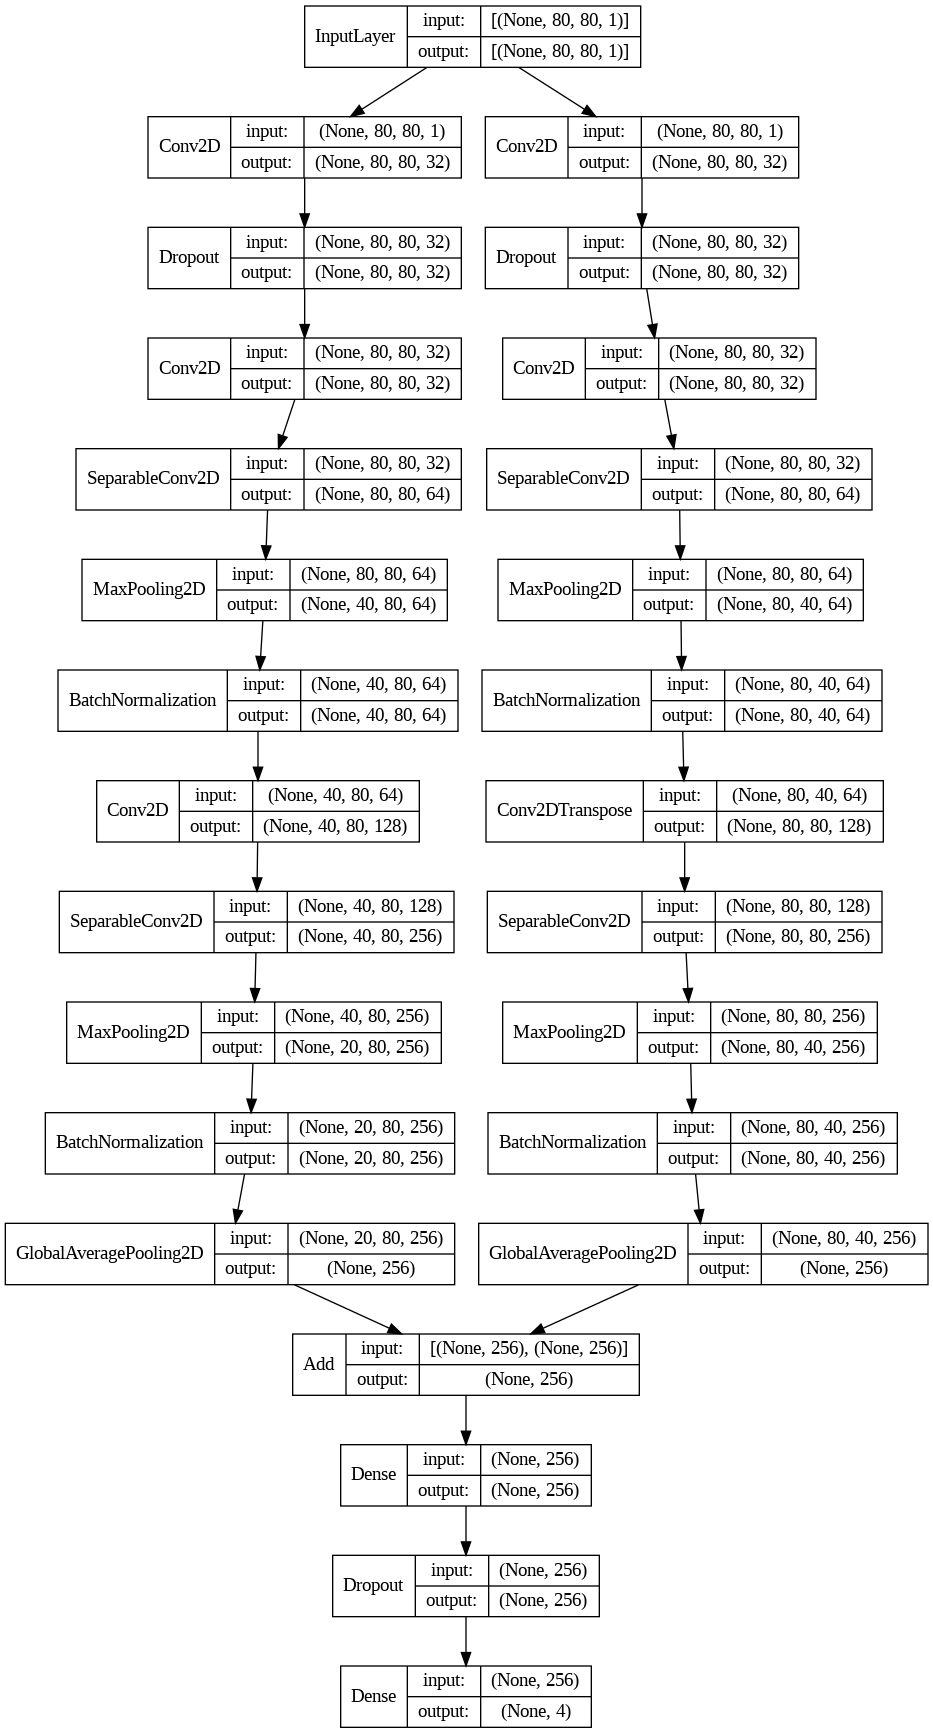

In [7]:
# visualize the model structure
keras.utils.plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=False)

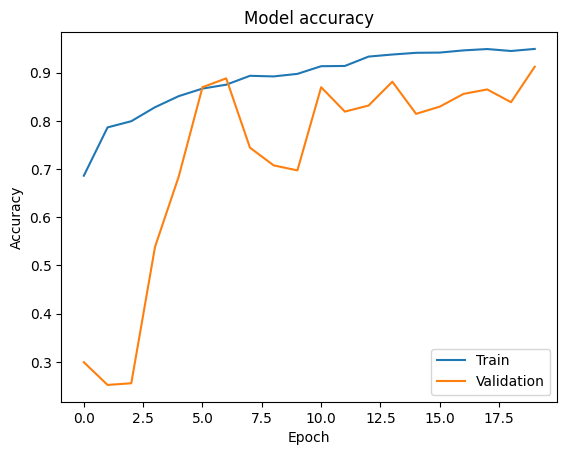

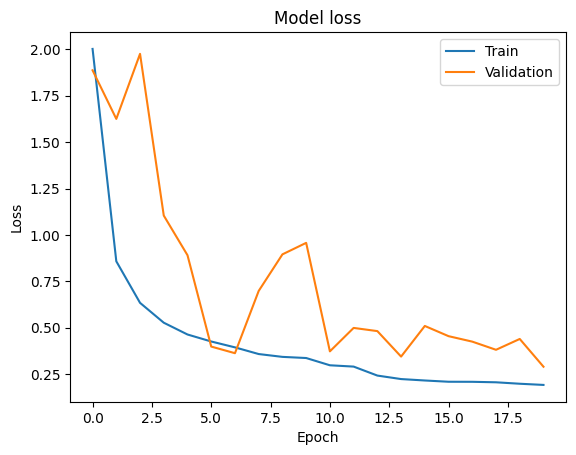

In [8]:
# plot training & validation accuracy values
plt.plot(history_lr.history['accuracy'])
plt.plot(history_lr.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# plot training & validation loss values
plt.plot(history_lr.history['loss'])
plt.plot(history_lr.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [9]:
# output test accuracy and test loss for the new model
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_accuracy}')


37/37 - 2s - loss: 0.2488 - accuracy: 0.9189 - 2s/epoch - 46ms/step
Test accuracy: 0.9189419746398926


In [10]:
from tensorflow.keras.models import load_model
#model_path = './drive/MyDrive/dual_stream_model.keras'
#model.save(model_path)
#model = load_model(model_path)

124/124 [==============================] - 6s 44ms/step


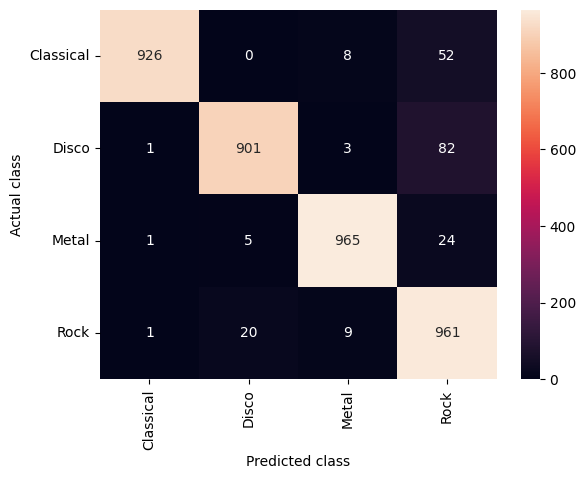

In [11]:
# predictions for the train set
y_pred_train = np.argmax(model.predict(x_train), axis=1)
y_true_train = np.argmax(y_train, axis=1)

# plotting the confusion matrix for the train set
plot_confusion_matrix(y_true_train, y_pred_train, labels=['Classical', 'Disco', 'Metal', 'Rock'])

37/37 [==============================] - 2s 44ms/step


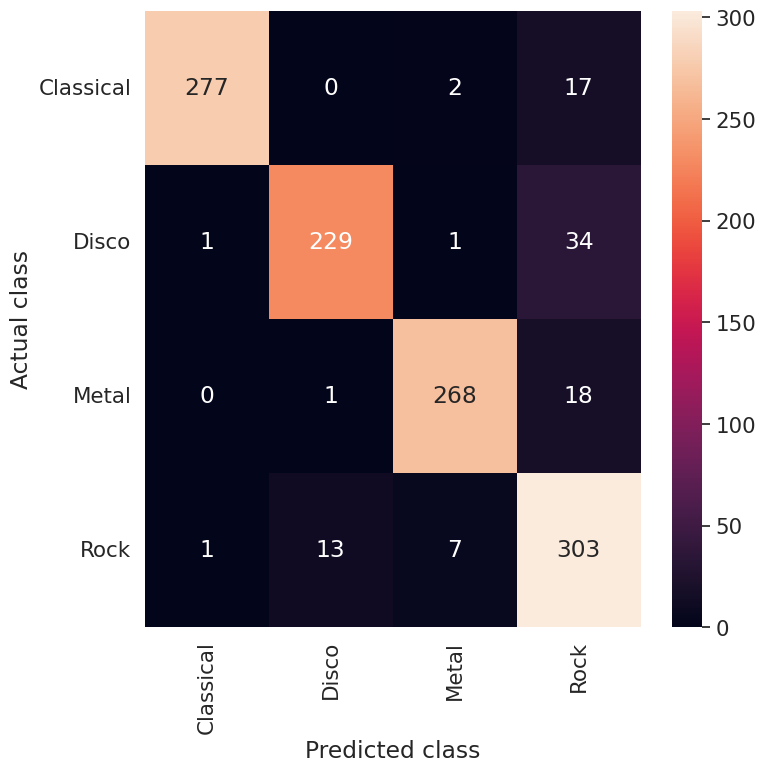

In [12]:
# predictions for the test set
y_pred_test = np.argmax(model.predict(x_test), axis=1)
y_true_test = np.argmax(y_test, axis=1)

# plotting the confusion matrix for the test set
plot_confusion_matrix(y_true_test, y_pred_test, labels=['Classical', 'Disco', 'Metal', 'Rock'])

The proposed dual-stream CNN architecture is designed specifically to address the characteristics of Mel spectrograms. Mel spectrograms represent audio signals in a two-dimensional format, where the x-axis corresponds to time and the y-axis to frequency, with intensities indicating the energy at various frequency bands over time. This representation captures temporal and spectral features of sound, which are relevant for distinguishing music genres.

### Justification of the Architecture:

1. **Dual-Stream Design**: The architecture splits into two parallel streams right from the input layer, one focusing on frequency (vertical axis) and the other on time (horizontal axis). This separation allows the model to independently learn and extract temporal and spectral features before combining them. This is particularly useful for Mel spectrograms, as it enables the model to capture the rhythmic patterns (time stream) and pitch characteristics (frequency stream) that are fundamental to identifying the genres. The streams are later combined by addition.

2. **Adaptive Filter Shapes**: In the frequency stream, filters are initially narrow and become broader/deeper in the network, designed to first capture fine-grained frequency details and then broader spectral patterns. Conversely, in the time stream, filters start shorter and widen, aiming to first pick up short temporal events and then longer temporal structures. This approach ensures that both detailed and abstract features are captured at different network depths.

3. **Separable Convolutions**: Used in both streams, separable convolutions efficiently model the interactions within each dimension (time or frequency) before combining them. This is helpful for handling the data of spectrograms without excessively increasing the computational cost.

4. **Global Average Pooling and Batch Normalization**: Global average pooling reduces each feature map to a single value, emphasizing the most important features for classification. Batch normalization is employed to stabilize and speed up training. In this case, stability of the training process is still unsatisfactory, altough additional measures such as early-stopping and adaptive learning rates were implemented.

5. **Regularization and Dropout**: To combat overfitting L2 regularization and dropout are strategically placed. These methods encourage the model to learn robust, generalizable patterns across genres, rather than memorizing the training data.

The proposed dual-stream CNN architecture adapts to the specific attributes of Mel spectrograms by processing temporal and spectral features through separate streams. This permits independent feature extraction, which are synthesized later.

### Training Process:

To ensure robust training, we employ a ReduceLROnPlateau callback for adaptive learning rate adjustments and an EarlyStopping callback for futher regularization. The learning rate is methodically reduced if no improvement in validation loss is observed, preventing ineffective model updates. EarlyStopping should mitigate overfitting by interrupting training when the validation loss no longer declines, reverting to the best performing weights. These measures aim to refine the model's ability to generalize and maintain stability throughout the training epochs.